
# Hyper-Parameter Tuning

<div align="center"> 
    <img src="https://raw.githubusercontent.com/optuna/optuna/master/docs/image/optuna-logo.png" style="width: 250px;"/>
</div>

Optimization and fine-tuning for the hyper-parameters using a novel framework named Optuna.

# Install

pyJedAI is an open-source library that can be installed from PyPI.


In [ ]:
%pip install pyjedai -U

In [ ]:
%pip show pyjedai

Imports

In [1]:
import plotly.express as px
import logging
import sys
import optuna
import plotly
import os
import sys
import pandas as pd
from optuna.visualization import *
import plotly.io as pio
import plotly.express as px
pio.templates.default = "plotly_white"

## Data Reading

In [3]:
from pyjedai.datamodel import Data

data = Data(
    dataset_1=pd.read_csv("./../data/ccer/D2/abt.csv", sep='|', engine='python', na_filter=False).astype(str),
    attributes_1=['id','name','description'],
    id_column_name_1='id',
    dataset_2=pd.read_csv("./../data/ccer/D2/buy.csv", sep='|', engine='python', na_filter=False).astype(str),
    attributes_2=['id','name','description'],
    id_column_name_2='id',
    ground_truth=pd.read_csv("./../data/ccer/D2/gt.csv", sep='|', engine='python'),
)

## WorkFlow

In [4]:
from pyjedai.workflow import WorkFlow, compare_workflows
from pyjedai.block_building import StandardBlocking, QGramsBlocking, ExtendedQGramsBlocking, SuffixArraysBlocking, ExtendedSuffixArraysBlocking
from pyjedai.block_cleaning import BlockFiltering, BlockPurging
from pyjedai.comparison_cleaning import WeightedEdgePruning, WeightedNodePruning, CardinalityEdgePruning, CardinalityNodePruning, BLAST, ReciprocalCardinalityNodePruning, ReciprocalWeightedNodePruning, ComparisonPropagation
from pyjedai.matching import EntityMatching
from pyjedai.clustering import ConnectedComponentsClustering

In [6]:
db_name = "pyjedai"
title = "Test"
storage_name = "sqlite:///{}.db".format(db_name)
study_name = title  # Unique identifier of the study.

## Objective function


In the bellow cell, we define which parameters we want to be fine-tuned and the boundaries that we suggest. Also we set as the goal score to be maximized the F1-Score.


In [7]:
'''
 OPTUNA objective function
'''
def objective(trial):
    
    w = WorkFlow(
        block_building = dict(
            method=QGramsBlocking, 
            params=dict(qgrams=trial.suggest_int("qgrams", 3, 10)),
            attributes_1=['name'],
            attributes_2=['name']
        ),
        block_cleaning = [
            dict(
                method=BlockPurging,
                params=dict(smoothing_factor=1.025)
            ),
            dict(
                method=BlockFiltering, 
                params=dict(
                    ratio = trial.suggest_float("ratio", 0.7, 0.95)
                )
            )
        ],
        comparison_cleaning = dict(method=CardinalityEdgePruning),
            entity_matching = dict(
            method=EntityMatching, 
            metric='sorensen_dice',
            similarity_threshold= trial.suggest_float("similarity_threshold", 0.05, 0.9),
            attributes = ['description', 'name']
        ),
        clustering = dict(method=ConnectedComponentsClustering),
        name="Worflow-Test"
    )
    w.run(data, workflow_step_tqdm_disable=True, verbose=False)
    f1, precision, recall = w.get_final_scores()
    
    return f1

In [8]:
study_name = title  # Unique identifier of the study.
num_of_trials = 30
study = optuna.create_study(
    directions=["maximize"],
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True
)
print("Optuna trials starting")
study.optimize(
    objective, 
    n_trials=num_of_trials, 
    show_progress_bar=True
)
print("Optuna trials finished")

[I 2022-09-26 17:11:56,515] A new study created in RDB with name: Test


Optuna trials starting


C:\Users\nikol\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-09-26 17:12:08,614] Trial 0 finished with value: 0.30337436666113177 and parameters: {'qgrams': 8, 'ratio': 0.8380947452182991, 'similarity_threshold': 0.34701140984689427}. Best is trial 0 with value: 0.30337436666113177.
[I 2022-09-26 17:12:30,648] Trial 1 finished with value: 0.20307681243216183 and parameters: {'qgrams': 5, 'ratio': 0.7929630924927731, 'similarity_threshold': 0.3138589895822442}. Best is trial 0 with value: 0.30337436666113177.
[I 2022-09-26 17:12:53,415] Trial 2 finished with value: 0.19103604207409036 and parameters: {'qgrams': 4, 'ratio': 0.8038691888459086, 'similarity_threshold': 0.1331382386125572}. Best is trial 0 with value: 0.30337436666113177.
[I 2022-09-26 17:12:58,756] Trial 3 finished with value: 0.28333512688101153 and parameters: {'qgrams': 7, 'ratio': 0.7144467000567123, 'similarity_threshold': 0.38959392590704467}. Best is trial 0 with value: 0.30337436666113177.
[I 2022-09-26 17:13:03,935] Trial 4 finished with value: 0.4633111426794054 an

# Optuna Visualizations

In [9]:
study.trials_dataframe(attrs=("number", "value", "params", "state"))

number     value  params_qgrams  params_ratio  \
0        0  0.303374              8      0.838095   
1        1  0.203077              5      0.792963   
2        2  0.191036              4      0.803869   
3        3  0.283335              7      0.714447   
4        4  0.463311             10      0.851762   
5        5  0.185319              3      0.917447   
6        6  0.190755              4      0.780872   
7        7  0.333308              9      0.800827   
8        8  0.397848              9      0.739514   
9        9  0.186269              3      0.859684   
10      10  0.648263             10      0.895726   
11      11  0.527413             10      0.904563   
12      12  0.426217             10      0.948302   
13      13  0.221129              7      0.896112   
14      14  0.407083              9      0.898364   
15      15  0.426217             10      0.948803   
16      16  0.212385              6      0.877724   
17      17  0.325844              8      0.920415   
18      18  0.348032              8      0.875184   
19      19  0.363919             10      0.829416   
20      20  0.209931              6      0.919676   
21      21  0.463307             10      0.856384   
22      22  0.407083              9      0.894854   
23      23  0.427457             10      0.842906   
24      24  0.407506              9      0.876132   
25      25  0.325841              8      0.927569   
26      26  0.463307             10      0.860103   
27      27  0.403764              9      0.766207   
28      28  0.363922             10      0.817486   
29      29  0.240802              7      0.838945   

    params_similarity_threshold     state  
0                      0.347011  COMPLETE  
1                      0.313859  COMPLETE  
2                      0.133138  COMPLETE  
3                      0.389594  COMPLETE  
4                      0.165802  COMPLETE  
5                      0.877713  COMPLETE  
6                      0.106831  COMPLETE  
7                      0.409487  COMPLETE  
8                      0.830695  COMPLETE  
9                      0.056876  COMPLETE  
10                     0.630360  COMPLETE  
11                     0.639230  COMPLETE  
12                     0.669716  COMPLETE  
13                     0.603679  COMPLETE  
14                     0.580814  COMPLETE  
15                     0.745462  COMPLETE  
16                     0.511488  COMPLETE  
17                     0.743528  COMPLETE  
18                     0.503516  COMPLETE  
19                     0.680822  COMPLETE  
20                     0.579547  COMPLETE  
21                     0.233232  COMPLETE  
22                     0.264418  COMPLETE  
23                     0.472672  COMPLETE  
24                     0.672677  COMPLETE  
25                     0.165060  COMPLETE  
26                     0.769505  COMPLETE  
27                     0.447988  COMPLETE  
28                     0.611068  COMPLETE  
29                     0.357438  COMPLETE

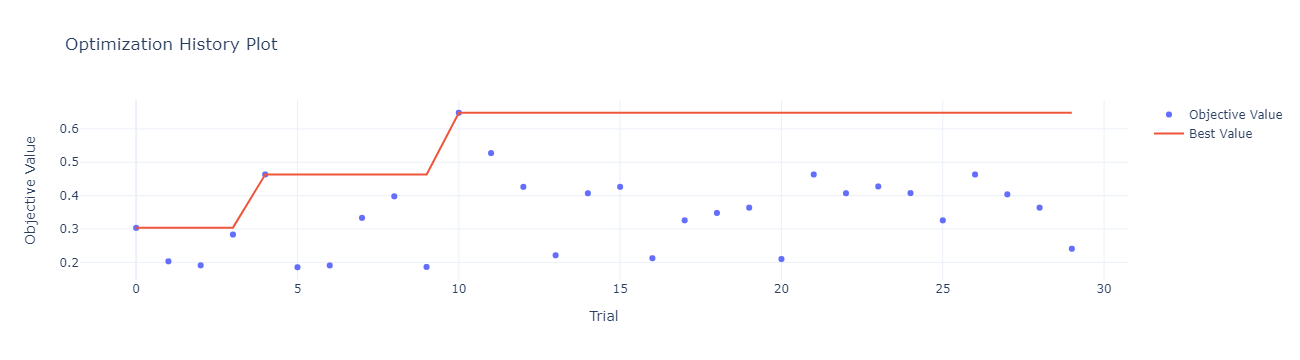

In [10]:
fig = plot_optimization_history(study)
fig.show()

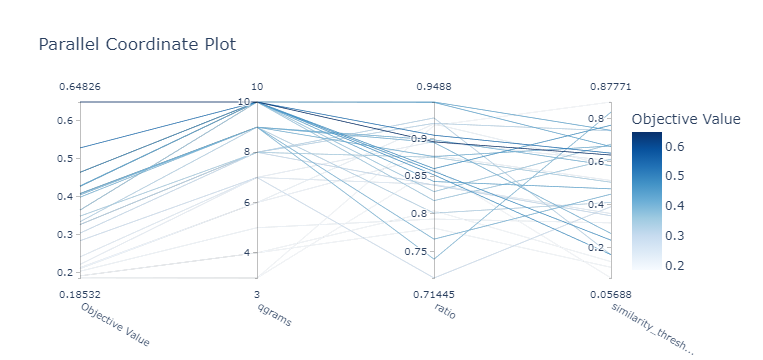

In [11]:
fig = plot_parallel_coordinate(study)
fig.show()

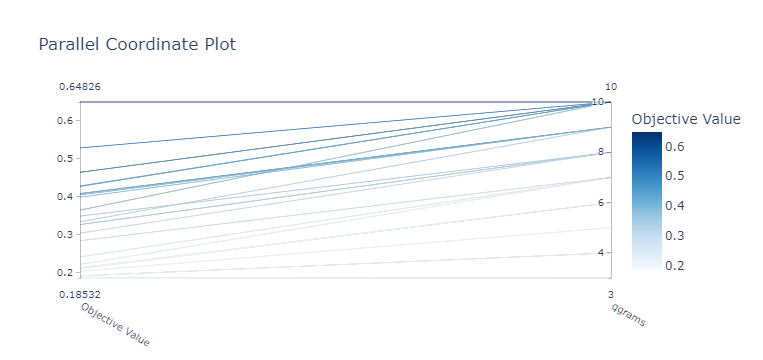

In [12]:
fig = plot_parallel_coordinate(study, params=["qgrams"])
fig.show()

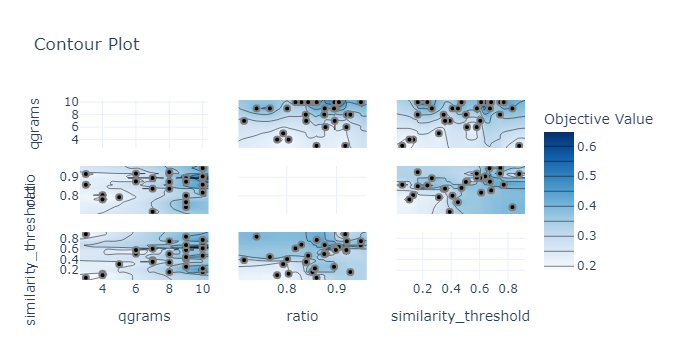

In [13]:
fig = plot_contour(study)
fig.show()

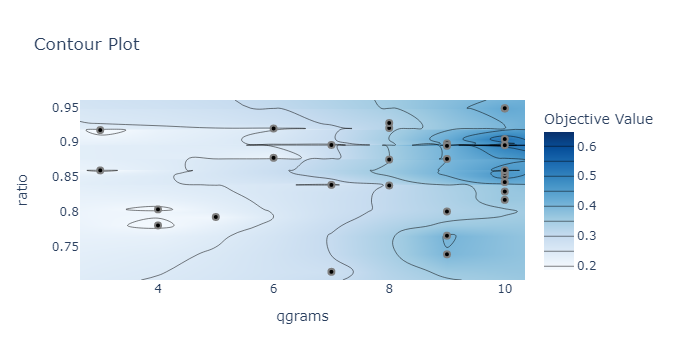

In [14]:
fig = plot_contour(study, params=["qgrams", "ratio"])
fig.show()

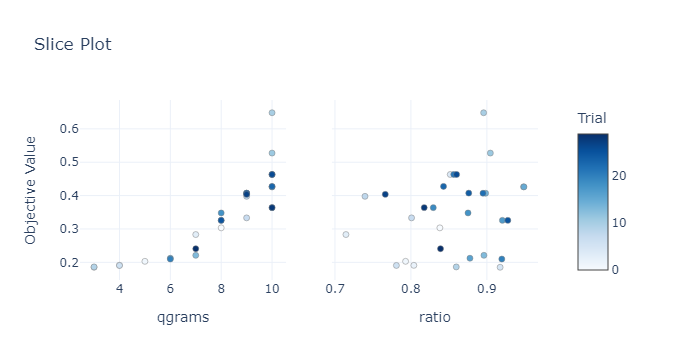

In [15]:
fig = plot_slice(study,  params=["qgrams", "ratio"])
fig.show()

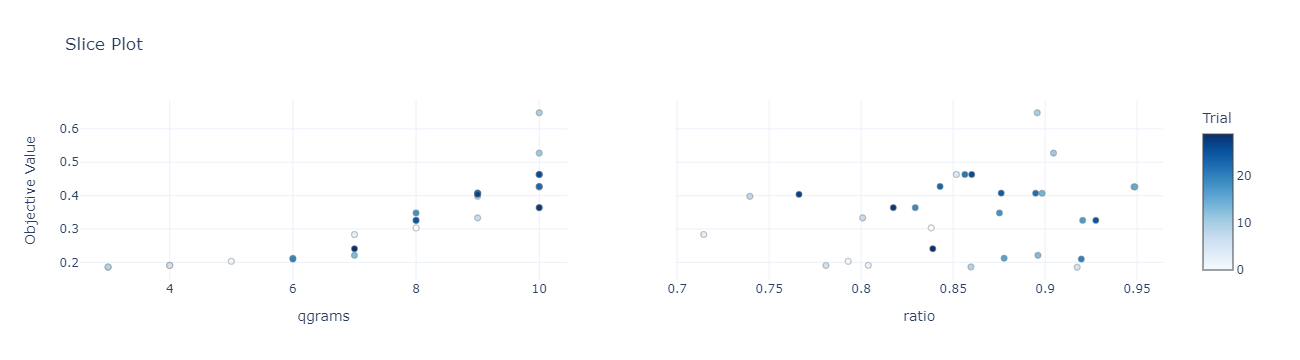

In [16]:
fig = plot_slice(study,  params=["qgrams", "ratio"])
fig.show()

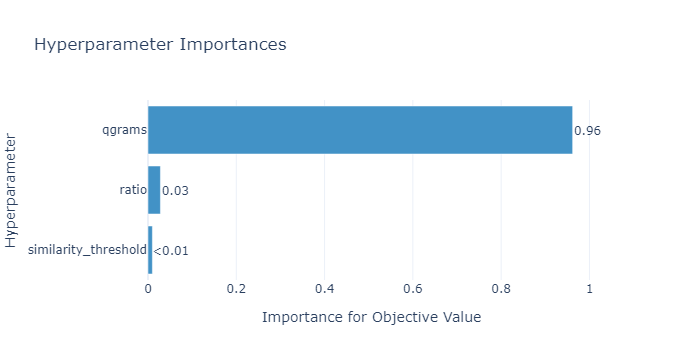

In [17]:
fig = plot_param_importances(study)
fig.show()

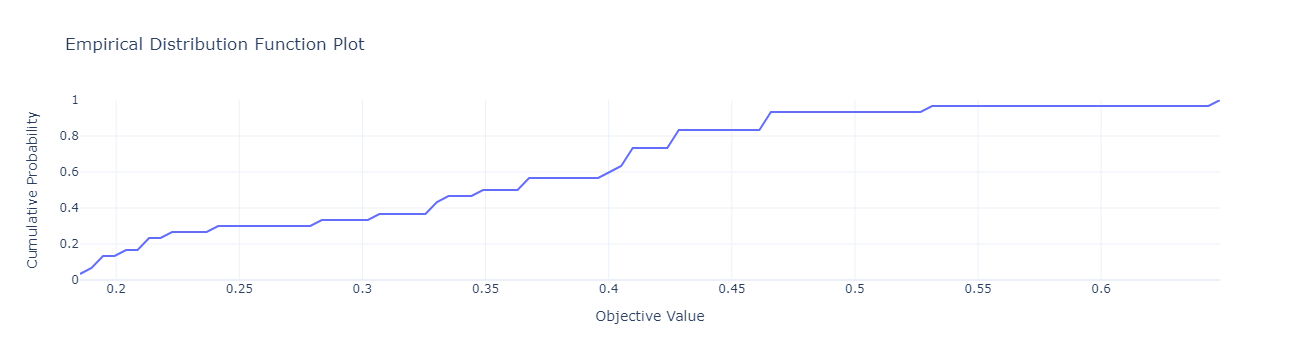

In [18]:
fig = plot_edf(study)
fig.show()

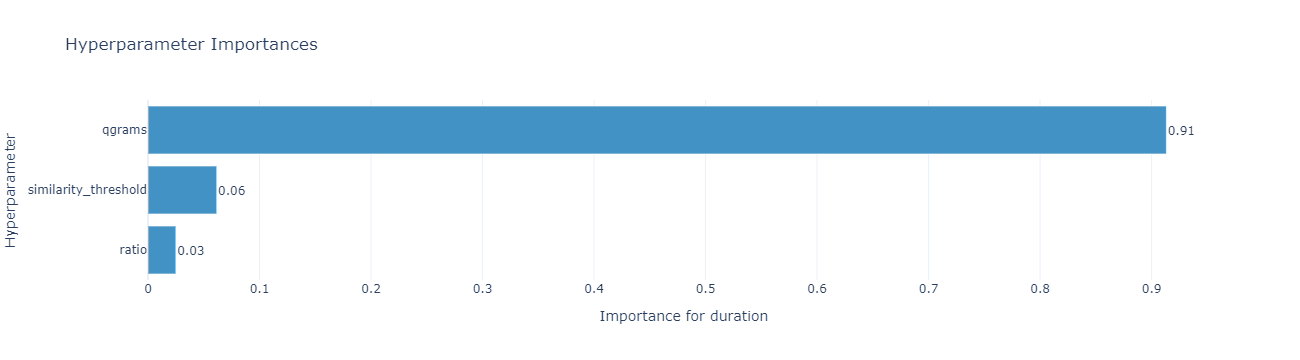

In [19]:
fig = optuna.visualization.plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)
fig.show()

<hr>
<div align="right">
K. Nikoletos, J. Maciejewski, G. Papadakis & M. Koubarakis
</div>
<div align="right">
<a href="https://github.com/Nikoletos-K/pyJedAI/blob/main/LICENSE">Apache License 2.0</a>
</div>